In [1]:
import  pandas as pd
import time, os
from pandas import DataFrame
import geopandas as gpd
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
from shapely.geometry import Point, MultiPoint, LineString, MultiLineString
from shapely import wkt
from shapely.ops import nearest_points, snap
from shapely.ops import unary_union
from shapely.geometry import shape, Point
import fiona
import networkx as nx
import pyproj
from pyproj import CRS

In [2]:
## Cost Parameters 

dollars_per_mile_rail=0.0063
dollars_per_mile_river=0.0049
dollars_per_mile_trail=0.231

miles_per_km=0.6213712

# 1 County data

In [3]:
counties = gpd.read_file('/home/seb/Desktop/GIS_Research_2021/5/data/missouri_p.shp')
# counties = gpd.read_file('/5/data/missouri_p.shp')

In [4]:
counties.head().T

,0,1,2,3,4
DECADE,1890,1890,1890,1890,1890
NHGISNAM,Saline,Sullivan,Nodaway,Washington,Camden
NHGISST,290,290,290,290,290
NHGISCTY,1950,2110,1470,2210,0290
ICPSRST,34,34,34,34,34
ICPSRCTY,1950,2110,1470,2210,290
ICPSRNAM,SALINE,SULLIVAN,NODAWAY,WASHINGTON,CAMDEN
STATENAM,Missouri,Missouri,Missouri,Missouri,Missouri
ICPSRSTI,34,34,34,34,34
ICPSRCTYI,1950,2110,1470,2210,290


In [5]:
print(counties.shape)
print(counties.drop_duplicates(subset='NHGISNAM').shape)

(115, 16)
(115, 16)


`NHGISNAM` uniquely identifies the rows. Let's just keep this as an identifier and the geometry but discard all other variables so as not to clutter the analysis.

In [6]:
counties = counties[['NHGISNAM', 'geometry']].copy().sort_values('NHGISNAM').reset_index(drop=True)

renaming the columns

In [7]:
counties.columns = ['county', 'geometry']

making sure we have the right projection

In [8]:
crs_p=CRS.from_string("esri:102003")

In [9]:
counties = counties.to_crs(crs_p)

In [10]:
counties.crs

<Projected CRS: ESRI:102003>
Name: USA_Contiguous_Albers_Equal_Area_Conic
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United States (USA) - CONUS onshore - Alabama; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming.
- bounds: (-124.79, 24.41, -66.91, 49.38)
Coordinate Operation:
- name: USA_Contiguous_Albers_Equal_Area_Conic
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

### Extracting counties' centroids from counties' polygons

In [11]:
county_centroids = gpd.GeoDataFrame({'geometry': counties.centroid,
                                     'county': counties.county})

<AxesSubplot:>

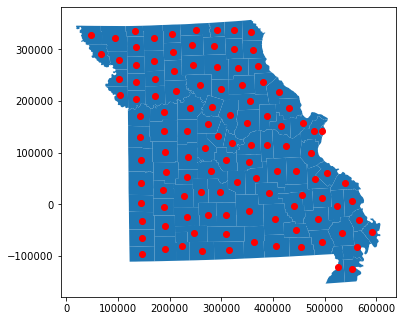

In [12]:
f, ax = plt.subplots(1,1, figsize=(6,6))
counties.plot(ax=ax)
county_centroids.plot(ax=ax, color='r')

# 2 Railway data in 1870

In [13]:
rail1870=gpd.read_file('/home/seb/Desktop/GIS_Research_2021/5/data/rail1870_p.shp').to_crs(crs_p)[['geometry']]

We now create the `cost` parameter that we will use when searching for the shortest paths. Note that we are computing the length of each line segment, which will give us a sensible result, since we are in the appropriate coordinate system. 

We now have a problem, however, since the centroids are not directly connected to the rail network. 

<AxesSubplot:>

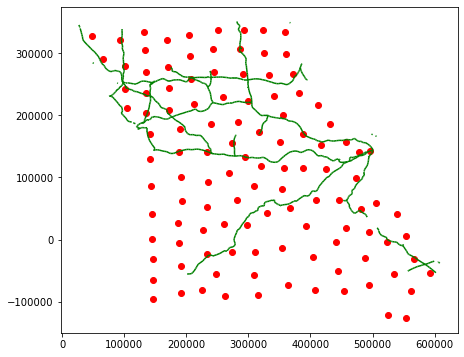

In [14]:
f, ax = plt.subplots(1, 1, figsize=(10, 6))
county_centroids.plot(ax=ax, color='r')
rail1870.plot(ax=ax, color='g')

# 3 Centroid-rail connectors

We will create straight-line connectors from the centroids to the railway. To create these straight lines, we need to find the coordinates of the point on the railway that is closest to each centroid. To accomplish this, we will dissolve the railway to be a single multiline. This is not strictly speaking necessary, but simplifies things.

In [15]:
rail1870["adm0"]=1
dissolved_rail = rail1870.dissolve(by='adm0').geometry
del rail1870['adm0']

In [16]:
dissolved_rail

adm0
1    MULTILINESTRING ((367158.620 349402.955, 36784...
Name: geometry, dtype: geometry

Now we are finding the location of the closest point on the railway network to each county centroid using a lambda function.

In [17]:
county_centroids['closest_point_on_rail'] = county_centroids.apply(lambda x: nearest_points(dissolved_rail.geometry[1],
                                                                                            x['geometry'])[0], axis=1)

In [18]:
county_centroids

,geometry,county,closest_point_on_rail
0,POINT (286830.348 306671.374),Adair,POINT (285999.4918468813 307317.5956230265)
1,POINT (101399.257 278966.255),Andrew,POINT (98432.71396283436 279707.8902513374)
2,POINT (48209.907 328584.311),Atchison,POINT (32827.40141619416 326123.1097468812)
3,POINT (355631.211 200100.178),Audrain,POINT (355151.2855037955 194940.977943441)
4,POINT (192117.956 -86356.187),Barry,POINT (201388.3877 -55557.2944)
...,...,...,...
110,POINT (445588.197 63738.095),Washington,POINT (453169.2749 63534.5029)
111,POINT (487273.765 -29210.092),Wayne,POINT (514206.457 6885.8117)
112,POINT (274342.442 -20058.145),Webster,POINT (267737.4958499722 -15654.84809856457)
113,POINT (132625.839 334969.734),Worth,POINT (96608.7834750669 333368.976106187)


we are now ready to draw the connector pieces

In [19]:
connector_rail = county_centroids.copy()
connector_rail['geometry'] = connector_rail.apply(lambda x: LineString([x['geometry'], x['closest_point_on_rail']]), axis=1)

deleting columns unnecessary for further analysis

In [20]:
del connector_rail["closest_point_on_rail"], county_centroids["closest_point_on_rail"]

In [21]:
connector_rail

,geometry,county
0,"LINESTRING (286830.348 306671.374, 285999.492 ...",Adair
1,"LINESTRING (101399.257 278966.255, 98432.714 2...",Andrew
2,"LINESTRING (48209.907 328584.311, 32827.401 32...",Atchison
3,"LINESTRING (355631.211 200100.178, 355151.286 ...",Audrain
4,"LINESTRING (192117.956 -86356.187, 201388.388 ...",Barry
...,...,...
110,"LINESTRING (445588.197 63738.095, 453169.275 6...",Washington
111,"LINESTRING (487273.765 -29210.092, 514206.457 ...",Wayne
112,"LINESTRING (274342.442 -20058.145, 267737.496 ...",Webster
113,"LINESTRING (132625.839 334969.734, 96608.783 3...",Worth


Putting all the pieces together thus far

<AxesSubplot:>

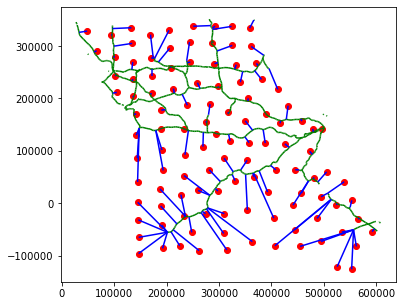

In [22]:
f, ax = plt.subplots(1, 1, figsize=(6, 6))
county_centroids.plot(ax=ax, color='r')
rail1870.plot(ax=ax, color='g')
connector_rail.plot(ax=ax, color='b')

# 4 Dealing with connectivity issues

The line segments we have created connecting centroids to railway do not reach the railway in some instances. This is a numerical precision problem and it prevents the network from being fully connected. We can only diagnose this problem further down, once we have defined the network. Here we will pre-empt this issue by extending the connector pieces by a small factor in both directions using the `scale` method.

We will use an exaggerated scale factor ($=1.5$) to make the scaling visible. For the further analysis, we will use a suffifient scale factor ($=1.00001$).

In [23]:
connector_rail_scaled = connector_rail.copy()
connector_rail_scaled_illustration = connector_rail.copy()
connector_rail_scaled['geometry'] = connector_rail_scaled.geometry.scale(xfact=1.00001, yfact=1.00001)
connector_rail_scaled_illustration['geometry'] = connector_rail_scaled.geometry.scale(xfact=1.5, yfact=1.5)

Ultimately, we will require a method for distinguishing nodes in the network that are **true** origins and destinations (the county centroids lying at the endpoints of the rail connectors) from ordinary network nodes that merely function as junctions along shortest paths. Since we will identify the true origins by their location, we will need to move the centroids to coincide with the modified rail connector pieces. This is accomplished by applying the following function. 

In [24]:
def snap_points_to_modified_connectors(points_gdf, connectors_gdf):
    
    out = points_gdf.copy()
    
    for index, row in points_gdf.iterrows():
        
        tmp_gdf = connectors_gdf.copy()
        tmp_gdf['distance'] = tmp_gdf.distance(row['geometry'])
        closest_geom = list(tmp_gdf.sort_values('distance')['geometry'])[0]
        closest_pts = [Point(coords) for coords in closest_geom.coords]
        dists = [row['geometry'].distance(x) for x in closest_pts]
        minimum = min(dists)
        minimum_index = [i for i, j in enumerate(dists) if j == minimum][0]      
        out.loc[index, 'geometry'] = closest_pts[minimum_index]
        
    return out

In [25]:
modified_centroids = snap_points_to_modified_connectors(county_centroids, connector_rail_scaled)
modified_centroids_illustration = snap_points_to_modified_connectors(county_centroids, connector_rail_scaled_illustration)

The following figure illustrates

- original county centroids
- modified county centroids
- the railways
- the scaled connector lines

For the two different scale factors.

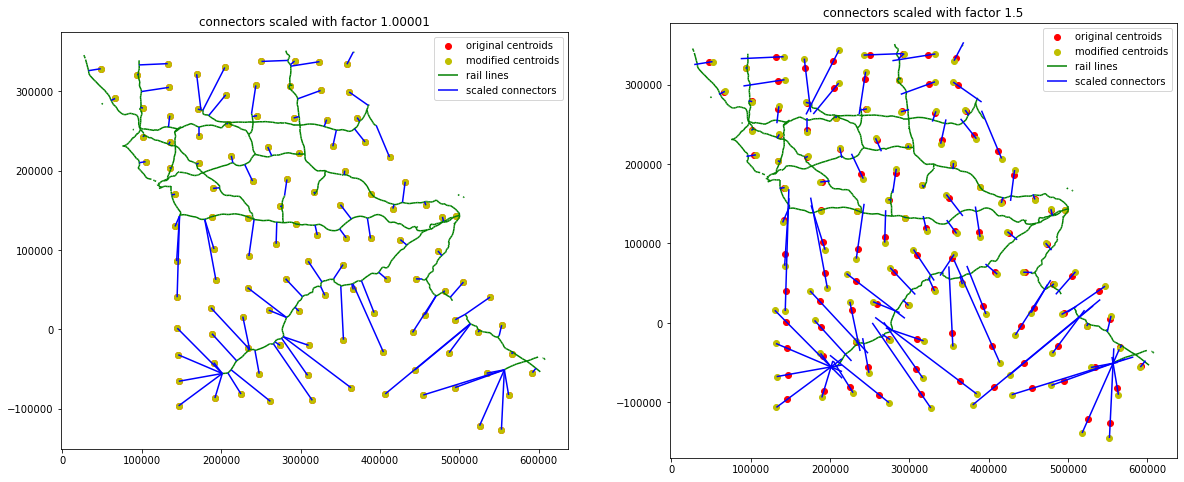

In [26]:
f, ax = plt.subplots(1, 2, figsize=(20, 10))

county_centroids.plot(ax=ax[0], color='r', label='original centroids')
modified_centroids.plot(ax=ax[0], color='y', label='modified centroids')
rail1870.plot(ax=ax[0], color='g', label='rail lines')
connector_rail_scaled.plot(ax=ax[0], color='b', label='scaled connectors')
ax[0].legend()
ax[0].set_title('connectors scaled with factor 1.00001')

county_centroids.plot(ax=ax[1], color='r', label='original centroids')
modified_centroids_illustration.plot(ax=ax[1], color='y', label='modified centroids')
rail1870.plot(ax=ax[1], color='g', label='rail lines')
connector_rail_scaled_illustration.plot(ax=ax[1], color='b', label='scaled connectors')
ax[1].legend()
ax[1].set_title('connectors scaled with factor 1.5')

plt.show()

In what follows we only work with the connectors scaled by a factor of $1.00001$.

# 5 Joining Rail and connector pieces

Later on, we will want to know which type of line segment we are dealing with to assign different costs. So we create the necessary variables here

In [27]:
rail1870['transport_type'] = 'rail'
connector_rail['transport_type'] = 'trail'
connector_rail_scaled['transport_type'] = 'trail'

In [28]:
joined = rail1870.append(connector_rail)
joined_scaled = rail1870.append(connector_rail_scaled)

To make the network routable, we need to split lines at points of intersection. For this we use `shapely.ops.unary_union`.

https://shapely.readthedocs.io/en/stable/manual.html#shapely.ops.unary_union

From the documentation: 

    "Areas of overlapping Polygons will get merged. LineStrings will get fully dissolved and noded. Duplicate Points will get merged."
    
This will ensure connectivity.

The issue we have, however, is that `unary_union` will change the number features and only returns a `GeoSeries` object, which means losing all the attributes. Luckily, a clever guy has figured out a solution:

https://gis.stackexchange.com/questions/380054/self-split-geopandas-linestring-geodataframe-in-a-fast-way-without-loosing-all-a

This will allow us to assign costs to line segments further down.

In [29]:
uun_joined = gpd.GeoDataFrame({'geometry': list(joined.geometry.unary_union)},
                              index = np.arange(len(joined.geometry.unary_union)), crs=crs_p)
uun_joined_scaled = gpd.GeoDataFrame({'geometry': list(joined_scaled.geometry.unary_union)},
                                     index = np.arange(len(joined_scaled.geometry.unary_union)), crs=crs_p)

Buffer the original geometry to avoid float arithmetic problems (in `intersects` or `within`)

In [30]:
joined_buff = joined.copy()
joined_scaled_buff = joined_scaled.copy()
joined_buff.geometry = joined_buff.geometry.buffer(0.0001)
joined_scaled_buff.geometry = joined_scaled_buff.geometry.buffer(0.0001)

Use a spatial join (with `within` or `intersect`) to join the two dataframes and retrieve the original attributes

In [31]:
uun_joined = gpd.tools.sjoin(uun_joined, joined_buff, how="inner", op='within').drop(['index_right'], axis=1)
uun_joined_scaled = gpd.tools.sjoin(uun_joined_scaled, joined_scaled_buff, how="inner", op='within').drop(['index_right'], axis=1)

In [32]:
uun_joined_scaled

,geometry,transport_type,county
0,"LINESTRING (367158.620 349402.955, 367848.782 ...",rail,NaN
1,"LINESTRING (282751.213 347460.836, 281487.782 ...",rail,NaN
2,"LINESTRING (499911.567 169945.958, 498500.279 ...",rail,NaN
3,"LINESTRING (504946.097 167361.614, 505786.453 ...",rail,NaN
4,"LINESTRING (505786.453 166570.691, 506225.131 ...",rail,NaN
...,...,...,...
1393,"LINESTRING (267737.496 -15654.848, 267737.463 ...",trail,Webster
1394,"LINESTRING (132626.019 334969.742, 96608.783 3...",trail,Worth
1395,"LINESTRING (96608.783 333368.976, 96608.603 33...",trail,Worth
1396,"LINESTRING (310125.722 -20010.588, 278352.679 ...",trail,Wright


# 6 Making a first graph to illustrate the connectivity issue and why we had to extend the connectors.

In [33]:
# taken from here:
# https://www.reddit.com/r/gis/comments/b1ui7h/geopandas_how_to_make_a_graph_out_of_a/

def gdf_to_nx(gdf_network):
    # generate graph from GeoDataFrame of LineStrings
    net = nx.Graph()
    net.graph['crs'] = gdf_network.crs
    fields = list(gdf_network.columns)

    for index, row in gdf_network.iterrows():
        first = row.geometry.coords[0]
        last = row.geometry.coords[-1]

        data = [row[f] for f in fields]
        attributes = dict(zip(fields, data))
        net.add_edge(first, last, **attributes)

    return net

In [34]:
nw = gdf_to_nx(uun_joined)
nw_scaled = gdf_to_nx(uun_joined_scaled)

## 6.1 Examining connectivity

In [35]:
centlist = [(x.xy[0][0], x.xy[1][0]) for x in  county_centroids.geometry]
centlist_mod = [(x.xy[0][0], x.xy[1][0]) for x in  modified_centroids.geometry]

In [36]:
cclist = list(nx.connected_components(nw))
cclist_scaled = list(nx.connected_components(nw_scaled))

In [37]:
n_ccomps = []
n_ccomps_scaled = []

for i, cent_data in enumerate(centlist):
    for ccs in cclist:
        if cent_data in ccs:
            n_ccomps.append((cent_data, county_centroids.loc[i, 'county'], len(ccs)))
for i, cent_data in enumerate(centlist_mod):            
    for ccs in cclist_scaled:
        if cent_data in ccs:
            n_ccomps_scaled.append((cent_data, county_centroids.loc[i, 'county'], len(ccs)))

In [38]:
ccomps_df = pd.DataFrame(n_ccomps, columns = ['centroid_coordindates', 'county_name', 'number_connected_components'])
ccomps_scaled_df = pd.DataFrame(n_ccomps_scaled, columns = ['centroid_coordindates', 'county_name', 'number_connected_components'])

In [39]:
ccomps_df

,centroid_coordindates,county_name,number_connected_components
0,"(286830.34777993977, 306671.37434743345)",Adair,2
1,"(101399.2566273574, 278966.2545852067)",Andrew,1126
2,"(48209.90688387828, 328584.3109648269)",Atchison,2
3,"(355631.21107901994, 200100.17838487553)",Audrain,2
4,"(192117.95626249057, -86356.1868242419)",Barry,1126
...,...,...,...
110,"(445588.19685037946, 63738.09491675391)",Washington,1126
111,"(487273.76450973446, -29210.091653666663)",Wayne,69
112,"(274342.4421311752, -20058.145473208388)",Webster,2
113,"(132625.8393774042, 334969.73434111464)",Worth,1126


In [40]:
ccomps_scaled_df

,centroid_coordindates,county_name,number_connected_components
0,"(286830.3519342194, 306671.37111632706)",Adair,1278
1,"(101399.27146007073, 278966.2508770284)",Andrew,1278
2,"(48209.98379640561, 328584.323270833)",Atchison,1278
3,"(355631.2134786478, 200100.2041808777)",Audrain,1278
4,"(192117.90991033337, -86356.34081870402)",Barry,1278
...,...,...,...
110,"(445588.1589449892, 63738.09593471399)",Washington,1278
111,"(487273.629846272, -29210.272133183433)",Wayne,88
112,"(274342.47515590664, -20058.16748969526)",Webster,1278
113,"(132626.0194626837, 334969.7423449058)",Worth,1278


In [41]:
ccomps_df['geometry'] = [Point(x) for x in ccomps_df.centroid_coordindates]
ccomps_scaled_df['geometry'] = [Point(x) for x in ccomps_scaled_df.centroid_coordindates]
ccomps_df = gpd.GeoDataFrame(ccomps_df, crs=crs_p)
ccomps_scaled_df = gpd.GeoDataFrame(ccomps_scaled_df, crs=crs_p)

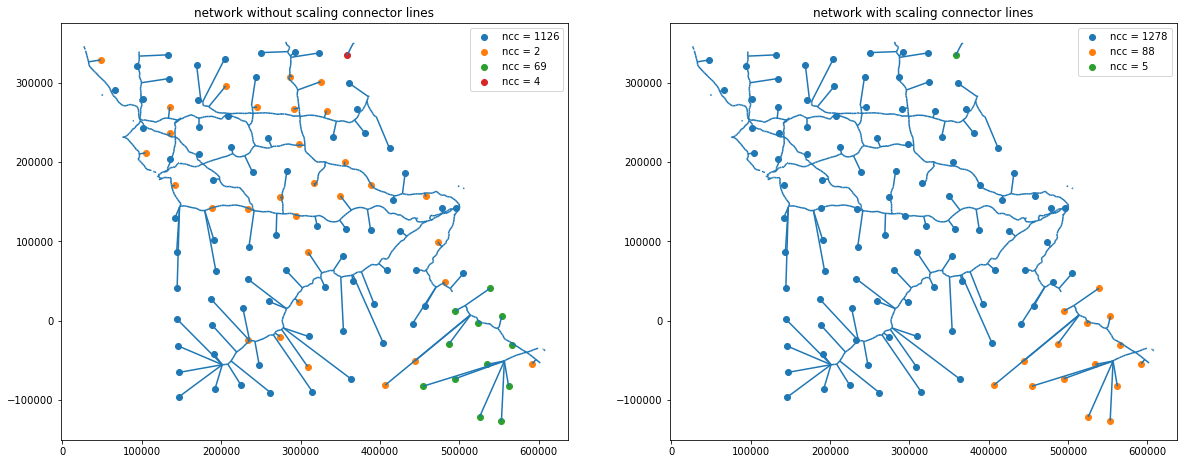

In [42]:
f, ax = plt.subplots(1, 2, figsize=(20, 10))
joined.plot(ax=ax[0])
joined_scaled.plot(ax=ax[1])
for ncc in ccomps_df.number_connected_components.value_counts().index:
    ccomps_df[ccomps_df.number_connected_components==ncc].plot(ax=ax[0], label=f'ncc = {ncc}')
for ncc in ccomps_scaled_df.number_connected_components.value_counts().index:
    ccomps_scaled_df[ccomps_scaled_df.number_connected_components==ncc].plot(ax=ax[1], label=f'ncc = {ncc}')
ax[0].legend()
ax[1].legend()
ax[0].set_title('network without scaling connector lines')
ax[1].set_title('network with scaling connector lines')
plt.show()

The figure above illustrates the number of connected network components for each county centroid. The graph on the right has scaled components. Aside from the centroids in the lower left and the lone centroid in the upper right, which are clearly in isolated parts of the network, all centroids are connected to all parts of the network. 

By contrast, a number of centroids in the graph on the left are not connected to the full network, despite appearing connected to the naked eye. Slightly extending the connector lines fixes this problem. 

From this point forward, we will only work with the version of the network that has the slightly extended connectors

# 7 Adding costs

Given that we had previously added a `transport_type` attribute to each line segment and we have recovered this attribute after `unary_union` using the `buffer` and `sjoin` trick above, adding costs is now very easy

In [43]:
uun_joined_scaled.transport_type.value_counts()

rail     1168
trail     230
Name: transport_type, dtype: int64

This shows that we have recovered exactly our 115 connectors. We are now able to assign costs to each line segment

In [44]:
uun_joined_scaled['cost'] = np.nan
uun_joined_scaled.loc[uun_joined_scaled.transport_type == 'rail', 'cost'] = (uun_joined_scaled.loc[uun_joined_scaled.transport_type == 'rail']
                                                                 .geometry.length*dollars_per_mile_rail*miles_per_km)
uun_joined_scaled.loc[uun_joined_scaled.transport_type == 'trail', 'cost'] = (uun_joined_scaled.loc[uun_joined_scaled.transport_type == 'trail']
                                                                  .geometry.length*dollars_per_mile_trail*miles_per_km)

In [45]:
uun_joined_scaled

,geometry,transport_type,county,cost
0,"LINESTRING (367158.620 349402.955, 367848.782 ...",rail,NaN,3.247083
1,"LINESTRING (282751.213 347460.836, 281487.782 ...",rail,NaN,15.953376
2,"LINESTRING (499911.567 169945.958, 498500.279 ...",rail,NaN,7.272623
3,"LINESTRING (504946.097 167361.614, 505786.453 ...",rail,NaN,4.517565
4,"LINESTRING (505786.453 166570.691, 506225.131 ...",rail,NaN,3.151017
...,...,...,...,...
1393,"LINESTRING (267737.496 -15654.848, 267737.463 ...",trail,Webster,0.005697
1394,"LINESTRING (132626.019 334969.742, 96608.783 3...",trail,Worth,5174.900351
1395,"LINESTRING (96608.783 333368.976, 96608.603 33...",trail,Worth,0.025874
1396,"LINESTRING (310125.722 -20010.588, 278352.679 ...",trail,Wright,4816.333985


# 8 Creating the network again, this time with cost parameter

In [46]:
nw = gdf_to_nx(uun_joined_scaled)

# 9 Finding the shortest path and dumping the results to a `pandas` DataFrame

In [47]:
all_costs = nx.shortest_path_length(nw, weight='cost')

`all_costs` is a `generator` object. (see here for more details: https://wiki.python.org/moin/Generators). For our purposes, all we need to know is that we can loop over a generator (but only once!). At each iteration of the loop we will get a tuple with two elements. The first element of the tuple will be the node coordinates. The second element is a dictionary, which has all nodes reachable from the current node as keys and costs as values. 

We first iteratively build a dictionary of dictionaries that associates with each county centroid a dictionary of centroid-cost key-value pairs from the `all_costs` generator.

In [48]:
d = {element[0] : {k: v for k, v in element[1].items() if k in centlist_mod} for element in all_costs if element[0] in centlist_mod}

We then iterate over the list of centroids to grab the elements from the dictionary and insert them into a list of lists into the right order. Finally, that list of lists is converted into a `pandas` dataframe. Note that at each step of the iteration, we also insert the county name. The order is correct since the `centlist_mod` list was generated from (and therefore has the order) the `modified_centroids` dataframe in the cell right underneath the section heading **"6.1 Examining connectivity"** above.

In [49]:
out = []
for centroid_i in centlist_mod:
    out_centi = []
    distance_dictionary_centroid_i = d[centroid_i]
    for centroid_j in centlist_mod:
        if centroid_j in distance_dictionary_centroid_i:
            out_centi.append(distance_dictionary_centroid_i[centroid_j])
        else:
            out_centi.append(np.nan)
    out.append(out_centi)
county_names = list(modified_centroids.county)
out = pd.DataFrame(out, index=county_names, columns=county_names)

In [50]:
out

,Adair,Andrew,Atchison,Audrain,Barry,Barton,Bates,Benton,Bollinger,Boone,...,Sullivan,Taney,Texas,Vernon,Warren,Washington,Wayne,Webster,Worth,Wright
Adair,0.000000,1732.386917,3841.284931,1503.446610,7634.893065,14560.882082,9699.410930,8112.773819,NaN,1146.554665,...,5838.289692,12095.550185,11815.742958,16231.868974,1797.901222,2910.489997,NaN,3831.040595,6683.137214,7457.385489
Andrew,1732.386917,0.000000,3189.330351,2477.822208,8302.704233,15228.693250,9378.162113,8016.471991,NaN,2120.930263,...,6371.745284,12763.361352,12483.554126,15910.620157,2772.276820,3884.865595,NaN,4498.851763,5828.580129,8125.196657
Atchison,3841.284931,3189.330351,0.000000,4586.720222,10411.602247,17337.591264,11487.060127,10125.370005,NaN,4229.828277,...,8480.643298,14872.259366,14592.452140,18019.518171,4881.174834,5993.763609,NaN,6607.749777,8140.080649,10234.094671
Audrain,1503.446610,2477.822208,4586.720222,0.000000,7618.917877,14544.906893,10177.130447,8590.493337,NaN,1324.112511,...,6611.064382,12079.574996,11799.767769,16709.588492,1781.926034,2894.514809,NaN,3815.065407,7428.572506,7441.410301
Barry,7634.893065,8302.704233,10411.602247,7618.917877,0.000000,16159.421439,15515.116736,13647.513244,NaN,7455.558966,...,12742.510837,13793.982938,15163.927467,22047.574780,7311.593335,7700.156647,NaN,6082.698452,13253.454531,9810.175545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Washington,2910.489997,3884.865595,5993.763609,2894.514809,7700.156647,14626.145664,11151.138764,9283.535273,NaN,2731.155898,...,8018.107769,12160.813766,11881.006540,17683.596809,2587.190267,0.000000,NaN,3896.304177,8835.615893,7522.649071
Wayne,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6921.88037,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
Webster,3831.040595,4498.851763,6607.749777,3815.065407,6082.698452,13008.687469,11711.264266,9843.660774,NaN,3651.706496,...,8938.658367,10543.355572,11360.074997,18243.722310,3507.740865,3896.304177,NaN,0.000000,9449.602061,6006.323075
Worth,6683.137214,5828.580129,8140.080649,7428.572506,13253.454531,20179.443547,14328.912411,12967.222289,NaN,7071.680560,...,11322.495582,17714.111650,17434.304423,20861.370455,7723.027118,8835.615893,NaN,9449.602061,0.000000,13075.946955
